<a href="https://colab.research.google.com/github/ganeshred/NLPAuthorshipAttributionNLM/blob/main/Attention_bi_LSTM_task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !apt-get update -y
# !apt-get install python3.9 python3.9-dev python3.9-distutils libpython3.9-dev

# !update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.8 1
# !update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 2

# !update-alternatives --config python3


In [2]:
# !curl https://bootstrap.pypa.io/get-pip.py -o get-pip.py
# !python3 get-pip.py --force-reinstall



In [3]:
!python --version

Python 3.10.11


In [4]:
# !pip freeze | grep torch

In [5]:
# !pip uninstall torch
# !pip install torch==1.8.0
# !pip uninstall torchtext
# !pip install torchtext==0.10.1


In [6]:
!pip install torchtext==0.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.2 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.1
    Uninstalling torchtext-0.15.1:
      Successfully uninstalled torchtext-0.15.1


In [7]:
from torchtext import data
from torchtext import datasets

In [8]:
# TEXT = data.Field(tokenize = 'spacy', include_lengths = True)
TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm')


In [9]:

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [10]:
import torch
from torchtext import data
from torchtext import datasets

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy',tokenizer_language = 'en_core_web_sm', include_lengths = True)
LABEL = data.LabelField(dtype = torch.float)

In [11]:
import pandas as pd

In [12]:
df = pd.read_csv('/content/Task3.csv')

In [13]:
len(df)

11726

In [14]:
df.head()

,Generation,label,label_int
0,Flint man facing 10 dog fighting and drug deal...,grover,5
1,the 30 most troubling lines from donald trump ...,ctrl,0
2,Wakayama rafting is a type of traditional raft...,instructgpt,7
3,The movies that predicted an outbreak like cor...,grover,5
4,companies that pay taxes are allowed to use ta...,pplm,8


In [15]:
df = df[['Generation','label']]

In [16]:
df[['Generation']] = df[['Generation']]. astype(str)

In [17]:
# text_field = data.Field(
#     sequential=True,
#     tokenize='basic_english', 
#     fix_length=500,
#     lower=True
# )
TEXT = data.Field(tokenize = 'spacy', tokenizer_language = 'en_core_web_sm', include_lengths = True)
LABEL = data.LabelField(sequential=False, use_vocab=False, dtype = torch.float)

# label_field = data.Field(sequential=False, use_vocab=False)

# sadly have to apply preprocess manually
preprocessed_text = df['Generation'].apply(
    lambda x: TEXT.preprocess(x)
)

# load fastext simple embedding with 300d
TEXT.build_vocab(
    preprocessed_text, 
    max_size = 30000,
    vectors='glove.6B.50d',
    unk_init = torch.Tensor.normal_
)

# get the vocab instance
vocab = TEXT.vocab

.vector_cache/glove.6B.zip: 862MB [02:42, 5.31MB/s]                           
100%|█████████▉| 399999/400000 [00:11<00:00, 33431.99it/s]


In [18]:
ltoi = {l: i for i, l in enumerate(df['label'].unique())}

In [19]:
df['label1'] = df['label'].apply(lambda y: ltoi[y])

class DataFrameDataset(data.Dataset):
    def __init__(self, df: pd.DataFrame, fields: list):
        super(DataFrameDataset, self).__init__(
            [
                data.Example.fromlist(list(r), fields) 
                for i, r in df.iterrows()
            ], 
            fields
        )

In [20]:
df1=df[['Generation','label1']]

In [21]:
examples=[]
for i,row in df1.iterrows():
  # print(example)
  examples.append(data.Example.fromlist(row, fields=[('text', TEXT), ('label', LABEL)]))

In [22]:
# examples[2000].label
c=0
for i in examples:
  if type(i.label) != int:
    c+=1

In [23]:
c

0

In [24]:
dataset = data.Dataset(examples, fields=[('text', TEXT), ('label', LABEL)])

In [25]:
train_dataset, test_dataset, valid_dataset = dataset.split(split_ratio=[0.65, 0.15, 0.2], stratified=True, strata_field='label')

In [26]:
len(train_dataset)

7623

In [27]:
ltoi

{'grover': 0,
 'ctrl': 1,
 'instructgpt': 2,
 'pplm': 3,
 'gpt2': 4,
 'xlnet': 5,
 'gpt': 6,
 'xlm': 7,
 'human': 8,
 'gpt3': 9,
 'fair': 10}

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("We are working with ", device)
# device = 'cpu'
train_iter, test_iter, valid_iter = data.BucketIterator.splits(
    datasets=(train_dataset, test_dataset, valid_dataset), 
    batch_size=32,
    sort_within_batch = True,
    sort_key=lambda x: len(x.text),
    device=device
)

We are working with  cuda


In [29]:
import torch.nn as nn

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.v = nn.Linear(self.hidden_size, 1, bias=False)
        
    def forward(self, hidden, encoder_outputs):
        # hidden = [batch size, hidden size]
        # encoder_outputs = [src sent len, batch size, hidden size]
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        # print(hidden.shape)
        # repeat the last hidden state of the decoder
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)

        # print(hidden.shape)
        # print(encoder_outputs.transpose(1,0).shape)

        # # hidden = hidden.transpose(1, 0)

        # print(hidden.shape)
        
        # concatenate hidden and encoder_outputs
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs.transpose(1,0)), dim=2))) 
        
        # compute attention scores
        attention = self.v(energy).squeeze(2)
        attention = torch.softmax(attention, dim=1).unsqueeze(1)
        # compute context vector
        # print(attention.shape)
        # print(encoder_outputs.shape)
        context = torch.bmm(attention, encoder_outputs.transpose(0, 1))
        return context, attention

class LSTMAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        super().__init__()
        #1. Initialize Embedding Layer
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=pad_idx)
        #2. Initialize LSTM layer
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=n_layers, dropout=dropout, bidirectional=bidirectional)
        #3. Initialize attention layer
        self.attention = Attention(hidden_dim*2)
        #4. Initialize a fully connected layer with Linear transformation
        self.fc = nn.Linear(hidden_dim*4, output_dim)
        #5. Initialize Dropout
        self.dropout = nn.Dropout(dropout)
        #6. Initialize a projection layer for hidden tensor
        if bidirectional:
            self.hidden_proj = nn.Linear(2*hidden_dim, 2*hidden_dim)
        else:
            self.hidden_proj = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, text, text_lengths):
        #1. Apply embedding layer that matches each word to its vector and apply dropout. Dim [sent_len, batch_size, emb_dim]
        embedding = self.embedding(text)
        embedding_dropout = self.dropout(embedding)
        #2. Run the LSTM along the sentences of length sent_len. #output = [sent len, batch size, hid dim * num directions]; #hidden = [num layers * num directions, batch size, hid dim]
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedding_dropout, text_lengths.to('cpu'), enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        finalhidden = hidden
        encoder_outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_output)
        #3. Compute the attention vector and apply attention to the encoder outputs
        if self.lstm.bidirectional:
            hidden = torch.tanh(self.hidden_proj(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
        else:
            hidden = torch.tanh(self.hidden_proj(hidden[-1,:,:]))
        # print(hidden.shape)
        # print(encoder_outputs.shape)
        context, attention = self.attention(hidden, encoder_outputs)
        # print(context.squeeze(1).shape)
        # finalhidden = finalhidden.unsqueeze(1)
        # print(torch.cat((finalhidden[-2,:,:], finalhidden[-1,:,:]), dim=1).shape)
        #4. Concatenate the final hidden state and the context vector
        output = torch.cat((torch.cat((finalhidden[-2,:,:], finalhidden[-1,:,:]), dim=1), context.squeeze(1)), dim=1)
        #5. Apply the fully connected layer and return the output
        output = self.dropout(output)
        return self.fc(output)



In [30]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 50
HIDDEN_DIM = 126
OUTPUT_DIM = 11
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = LSTMAttention(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT,
            PAD_IDX)

In [31]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,259,387 trainable parameters


In [32]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([30002, 50])


In [33]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  0.7372,  0.3910,  0.5158],
        [ 0.1825, -0.0737,  0.3147,  ...,  1.3226, -2.6796, -0.1297],
        [ 0.4180,  0.2497, -0.4124,  ..., -0.1841, -0.1151, -0.7858],
        ...,
        [-0.9581,  0.5661,  0.2489,  ..., -0.4387, -0.5074,  1.0205],
        [-0.1401, -0.3614, -0.8919,  ...,  0.4649,  0.3368,  0.6853],
        [ 0.1328, -0.4302,  0.0057,  ..., -1.4743,  1.7457,  0.2557]])

In [34]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4180,  0.2497, -0.4124,  ..., -0.1841, -0.1151, -0.7858],
        ...,
        [-0.9581,  0.5661,  0.2489,  ..., -0.4387, -0.5074,  1.0205],
        [-0.1401, -0.3614, -0.8919,  ...,  0.4649,  0.3368,  0.6853],
        [ 0.1328, -0.4302,  0.0057,  ..., -1.4743,  1.7457,  0.2557]])


In [35]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [36]:
criterion = nn.CrossEntropyLoss()

# device='cpu'
model = model.to(device)
criterion = criterion.to(device)

In [37]:
def multiclass_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    # get the index of the highest prediction for each instance
    _, preds = torch.max(preds, dim=1)
    correct = (preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc


In [38]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        # print(batch.text)
        text, text_lengths = batch.text
        # print(torch.tensor(text))
        
        predictions = model(text, text_lengths).squeeze(1)

        target = batch.label
        target = target.type(torch.LongTensor)

        # print(target.shape)

        # print(predictions.shape)
        
        loss = criterion(predictions.to(device), target.to(device))
        
        acc = multiclass_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [39]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
            
            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze(1)
            target = batch.label
            target = target.type(torch.LongTensor)
            
            loss = criterion(predictions.to(device), target.to(device))
            
            acc = multiclass_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()



    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [40]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [41]:
train_losses_list = []
valid_losses_list = []
train_accs=[]
valid_accs=[]

In [42]:
N_EPOCHS = 20
path = F"/content/gdrive/My Drive/attentionbilstm_model_task3.pt"
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
  
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iter, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iter, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    train_losses_list.append(train_loss)
    valid_losses_list.append(valid_loss)
    train_accs.append(train_acc*100)
    valid_accs.append(valid_acc*100)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), path)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 18s
	Train Loss: 1.919 | Train Acc: 29.46%
	 Val. Loss: 1.259 |  Val. Acc: 54.32%
Epoch: 02 | Epoch Time: 0m 17s
	Train Loss: 1.075 | Train Acc: 58.21%
	 Val. Loss: 0.798 |  Val. Acc: 68.01%
Epoch: 03 | Epoch Time: 0m 17s
	Train Loss: 0.712 | Train Acc: 70.45%
	 Val. Loss: 0.666 |  Val. Acc: 71.70%
Epoch: 04 | Epoch Time: 0m 17s
	Train Loss: 0.575 | Train Acc: 75.36%
	 Val. Loss: 0.545 |  Val. Acc: 74.72%
Epoch: 05 | Epoch Time: 0m 18s
	Train Loss: 0.518 | Train Acc: 77.67%
	 Val. Loss: 0.531 |  Val. Acc: 76.70%
Epoch: 06 | Epoch Time: 0m 18s
	Train Loss: 0.456 | Train Acc: 80.05%
	 Val. Loss: 0.499 |  Val. Acc: 77.90%
Epoch: 07 | Epoch Time: 0m 17s
	Train Loss: 0.381 | Train Acc: 83.34%
	 Val. Loss: 0.466 |  Val. Acc: 80.28%
Epoch: 08 | Epoch Time: 0m 18s
	Train Loss: 0.367 | Train Acc: 84.60%
	 Val. Loss: 0.516 |  Val. Acc: 79.09%
Epoch: 09 | Epoch Time: 0m 18s
	Train Loss: 0.332 | Train Acc: 86.17%
	 Val. Loss: 0.472 |  Val. Acc: 80.23%
Epoch: 10 | Epoch T

In [43]:
test_loss, test_acc = evaluate(model, test_iter, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.414 | Test Acc: 86.19%


In [44]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_true = []
y_pred = []

model.load_state_dict(torch.load(path))
model=model.to(device)

for batch in test_iter:
    text, labels = batch
    text,text_length=text
    text_length = text_length.to('cpu')
    predictions = model(text,text_length).squeeze(1)
    y_true.extend(labels.tolist())
    y_pred.extend(predictions.argmax(dim=1).tolist())  # convert to list of labels

# calculate the evaluation metrics using sklearn's functions
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)

Accuracy: 0.8681177976952625
Precision: 0.8691111698048041
Recall: 0.8681177976952626
F1 score: 0.8679250559916216


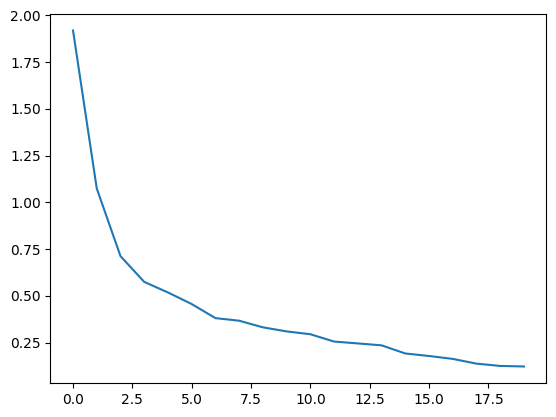

In [45]:
import matplotlib.pyplot as plt

plt.plot(train_losses_list)

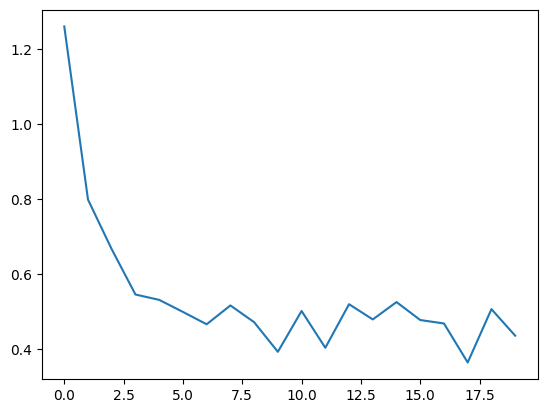

In [46]:
plt.plot(valid_losses_list)

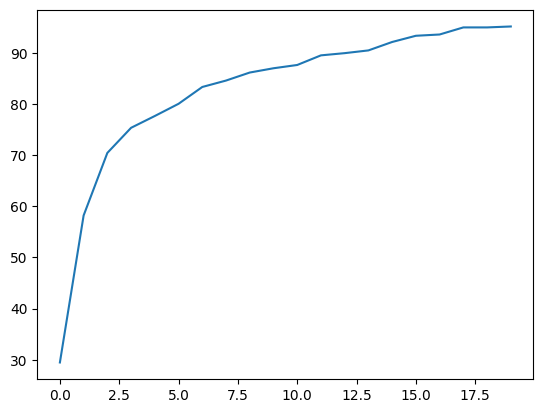

In [47]:
plt.plot(train_accs)

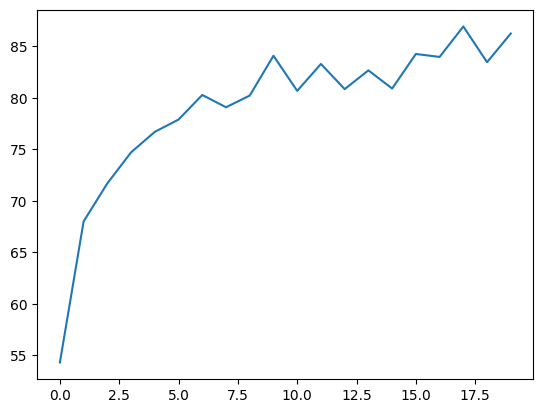

In [48]:
plt.plot(valid_accs)

In [49]:
reddit_gpt3 = pd.read_csv('/content/gdrive/MyDrive/NLP/reddit_data_gpt3.csv')
reddit_gpt3.head()
reddit_gpt3['text'] = reddit_gpt3['Generated Text'] + reddit_gpt3['Body'] + reddit_gpt3['Title']
reddit_gpt3 = reddit_gpt3[['text']]

FileNotFoundError: ignored

In [ ]:
ltoi

In [ ]:
reddit_gpt3['label'] = 9

In [ ]:
def dataframetodataset(df):
  examples=[]
  for i,row in df.iterrows():
    # print(example)
    examples.append(data.Example.fromlist(row, fields=[('text', TEXT), ('label', LABEL)]))
    dataset = data.Dataset(examples, fields=[('text', TEXT), ('label', LABEL)])
    # train_dataset, test_dataset, valid_dataset = dataset.split(split_ratio=[0.4, 0.3, 0.3], stratified=True, strata_field='label')
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # print("We are working with ", device)
    # train_iter, test_iter, valid_iter = data.BucketIterator.splits(
    #     datasets=(train_dataset, test_dataset, valid_dataset), 
    #     batch_size=16,
    #     sort_within_batch = True,
    #     sort_key=lambda x: len(x.text),
    #     device=device
    # )
  return dataset#,train_iter,test_iter,valid_iter

In [ ]:
dataset = dataframetodataset(reddit_gpt3)
train_dataset, test_dataset, valid_dataset = dataset.split(split_ratio=[0.4, 0.3, 0.3], stratified=True, strata_field='label')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("We are working with ", device)
train_iter, test_iter, valid_iter = data.BucketIterator.splits(
    datasets=(train_dataset, test_dataset, valid_dataset), 
    batch_size=16,
    sort_within_batch = True,
    sort_key=lambda x: len(x.text),
    device=device
)
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 50
HIDDEN_DIM = 126
OUTPUT_DIM = 11
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = LSTMAttention(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT,
            PAD_IDX)


In [50]:
model.load_state_dict(torch.load(path))
model = model.to(device)


In [51]:
evaluate(model, test_iter, criterion)

(0.37476516926835757, 0.8695101351351351)

In [52]:
evaluate(model, valid_iter, criterion)

(0.36450396247991274, 0.8693181818181818)

In [ ]:
# evaluate(model, train_iter, criterion)

In [53]:
def evaluate(model, dataloader):
    model.eval()
    device = next(model.parameters()).device
    running_loss = 0.0
    correct_predictions = 0
    class_correct = [0] * 11
    class_total = [0] * 11

    with torch.no_grad():
        for batch in dataloader:   
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
            target = batch.label
            target = target.type(torch.LongTensor)
            
            loss = criterion(predictions.to(device), target.to(device))
            
            # acc = multiclass_accuracy(predictions, batch.label)
            _, predicted = torch.max(predictions, dim=1)
            correct_predictions += torch.sum(predicted.to(device) == target.to(device)).item()

            for i in range(len(target)):
                label = target[i]
                class_correct[label] += int(predicted[i] == label)
                class_total[label] += 1

            # epoch_loss += loss.item()
    # epoch_loss = running_loss / len(dataloader)
    # epoch_acc = correct_predictions / len(dataloader)
    classwise_acc = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(11)]
    return classwise_acc

In [54]:
evaluate(model,train_iter)

[0.9971139971139971,
 0.9985569985569985,
 0.9422799422799423,
 0.9855699855699855,
 0.9696969696969697,
 0.9971139971139971,
 1.0,
 1.0,
 0.9971139971139971,
 0.961038961038961,
 0.9552669552669553]

In [55]:
evaluate(model,test_iter)

[0.9154929577464789,
 0.9906103286384976,
 0.7652582159624414,
 0.812206572769953,
 0.6431924882629108,
 0.9906103286384976,
 1.0,
 1.0,
 0.9812206572769953,
 0.7183098591549296,
 0.7323943661971831]

In [56]:
ltoi

{'grover': 0,
 'ctrl': 1,
 'instructgpt': 2,
 'pplm': 3,
 'gpt2': 4,
 'xlnet': 5,
 'gpt': 6,
 'xlm': 7,
 'human': 8,
 'gpt3': 9,
 'fair': 10}